This notebook is designed to test the SemiNFG solvers.  This includes BestResponse, RLK, both with and without the QRE.  However, this notebook is also an excellent example script that shows exactly how to use PyNFG.

There are two players, Trey ($T$) and Mike ($M$).  They are owners of firms that compete in the same market.  They need to decide how much to produce next period.  For simplicity, suppose they can only produce 10, 20, 30, 40, 50 or 60 units of product.  Trey and Mike do not communicate and must act simultaneously.  Furthermore, suppose that the market demand function can be either $Q_{1} =\alpha_1-\beta_1 P_i$ with probability $q$ or $Q_{2} = \alpha_2-\beta_2 P_2$.  Assume that Trey observes the market demand function exactly but Mike does not. Instead assume that Mike observes a signal, $S_1$ or $S_2$.  When demand is given by $Q_1$, Mike receives the signal $S_1$ with probability $s_1$.  When there is low demand, Mike receives the signal of $S_2$ with probability $s_2$.  Finally, each firm has a per unit cost of \$$1$ and no fixed costs. As a result utility functions are simply profit functions given by $profit_i = Q_iP^* - Q_i$, where $P^*$ is determined by the production decisions of both firms.  Assume that the demand functions, $q$ and $m_{1,2}$ are common knowledge. In principle this is a simple Cournot model where one player does not observe market demand perfectly. 

To ground the example, we can define the parameters here:

$\alpha_1 = 100, \;
\alpha_2 =  90$

$\beta_1 = .5,\;\beta_2 = 1$

$q = .5$

$s_1 = .8, \;s_2 = .7$


The inverse demand functions are given by:

$P_d = \frac{Q_d-\alpha_d}{\beta_d}$ for $d= 1,2$

Trey seeks to maximize:

$\displaystyle\max_Q\mathbf{E}\big[\frac{Q_M + Q_T-\alpha_d}{\beta_d} (Q_M + Q_T) -Q_T\big]$ for $d=1,2$

Since this is a level-k scenario, Trey's level 1 strategy depends on his beliefs of Mike's level 0 strategy.  As is common, this example assumes that the level 0 distribution on both players are uniform.  We can then calculate Trey's expected utility for each possible strategy:

Trey picks


to maximize:




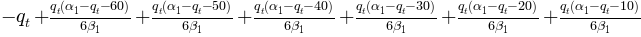



Which Simplifies to:




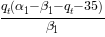

In [62]:
from sympy.stats import FiniteRV, E
from sympy import symbols, init_printing, Function, Rational, evalf
from sympy.abc import alpha, beta
from sympy.simplify import simplify
from sympy.interactive import printing
printing.init_printing()
init_printing(use_latex=True)
a1, a2, b1, b2, qm, qt = symbols("alpha_1 alpha_2 beta_1 beta_2 q_m q_t")
mikes_q0 = FiniteRV('Q_M', dict(zip(np.arange(10, 70, 10), [Rational(1,6)]*6))) # Distribution over Mike's actions
eu = E((-1*(mikes_q0 + qt -a1)/b1)*(qt) -qt) # Expected Utility
from IPython.display import display
print 'Trey picks' 
display(qt)
print 'to maximize:'
print '\n'
display(eu)
print '\n'
print 'Which Simplifies to:'
print '\n'
display(simplify(eu))

Now, we could use sympy to find the derivative and solve but since the domain is a finite set, we will just iterate through and record the expected utilities.

In [63]:
trey_eu_l1_d1 = {} # Trey's level 1 expected utilities with Demand 1
for qtrey in range(10,70,10):
    eu_numeric = eu.evalf(subs=dict(zip([a1,b1, qt],[100, .5, qtrey])))
    trey_eu_l1_d1[qtrey] =eu_numeric
trey_eu_l1_d1

{10: 1090.0, 20: 1780.0, 30: 2070.0, 40: 1960.0, 50: 1450.0, 60: 540.0}

We can do the same for a low market, just by changing the parameters in the evalf function

In [64]:
trey_eu_l1_d2 = {} # Trey's level 1 expected utilities with a Demand 2
for qtrey in range(10,70,10):
    eu_numeric = eu.evalf(subs=dict(zip([a1,b1, qt],[90, 1, qtrey])))
    trey_eu_l1_d2[qtrey] =eu_numeric
trey_eu_l1_d2

{10: 440.0, 20: 680.0, 30: 720.0, 40: 560.0, 50: 200.0, 60: -360.0}

If Trey is best responding without error (i.e. not quantal responding), his level 1 strategy would be to produce thirty regardless of the market demand he observes.  If he is quantal responding, his level 1 strategy is a mixed strategy.  If we assume that the $\beta$ parameter is .01, Trey's level 1 quantal response strategy is given by:

In [65]:
import numpy as np
trey_qre_l1_d1 = {}
denom = np.sum(np.exp(np.float_(np.asarray(trey_eu_l1_d1.values())*.01)))
for key, val in trey_eu_l1_d1.iteritems():
    trey_qre_l1_d1[key] = np.exp(float(val)*.01)/denom
trey_qre_l1_d2 = {}
denom = np.sum(np.exp(np.float_(np.asarray(trey_eu_l1_d2.values())*.01)))
for key, val in trey_eu_l1_d2.iteritems():
    trey_qre_l1_d2[key] = np.exp(float(val)*.01)/denom
    

In [66]:
print 'Trey\'s level 1 qre strategy with demand 1 is'
trey_qre_l1_d1

Trey's level 1 qre strategy with demand 1 is


{10: 3.9893827872e-05, 20: 0.0395856367061, 30: 0.719435116038, 40: 0.23947914
6726, 50: 0.00146004366531, 60: 1.63036956318e-07}

In [67]:
print 'Trey\'s level 1 qre strategy with demand 2 is'
trey_qre_l1_d2

Trey's level 1 qre strategy with demand 2 is


{10: 0.0313686189717, 20: 0.345781819742, 30: 0.515845858686, 40: 0.1041474826
91, 50: 0.00284569691062, 60: 1.05229993539e-05}

Mike's Level 1 strategy is slightly more complex because he needs to use Bayes rule to form beliefs about the true state of the market given his signal. Specifically, he needs to maximize

$P(demand=1|signal)\mathbf{E}[U_1(Q_M)] + P(demand=2|signal)\mathbf[{E}U_2(Q_M)]$, where $U_1$ and $U_2$ are Mike's profit functions.

In [68]:
# These functions give Mike's belief probabilities of demand 1 and demand 2
# given the signal he receives:

s1 = .8 # P(demand=1 | s1)
s2 = .3 # P(demand =1 | s2)

def phigh(signal):
    if signal =='h':
        return s1*.5/(s1*.5 +s2*.5)
    if signal == 'l':
        return .5*(1-s1)/(.5*(1-s1) + .5 * (1-s2))

def plow(signal):
    if signal =='h':
        return s2*.5/(s2*.5 + s1*.5)
    if signal =='l':
        return .5 *(1-s2) / (.5*(1-s2) + .5*(1-s1))
plow('l') == 1-phigh('l') # Should be true

In [69]:
## This cell generalizes what was done in Trey's optimization.  Given a set of quantities Q,
## and a probability distribution over what the opponent will do, these functions calculate
## the expected utility for all elements of Q. 


def EU_H(Q, probsopp =np.ones(6)/6.):
    """ Calculates expected utility when demand=1 given a quantity vector and probability
    distribution representing the other player's strategy"""
    eus = []
    strats = np.arange(10,70,10)
    for i in Q:
        u = probsopp*(i*(200-2*i-2*strats) - i)
        eus.append(np.sum(u))
    return np.asarray(eus)

def EU_L(Q, probsopp =np.ones(6)/6):
    """ Calculates expected utility when demand=2 given a quantity vector and probability
    distribution representing the other player's strategy"""
    eus = []
    strats = np.arange(10,70,10)
    for i in Q:
        u = probsopp* (i*(90-i-strats)-i)
        eus.append(np.sum(u))
    return np.asarray(eus)

In [70]:
## Given Expected utilities and Beta parameter, calculate the QRE
def lqre(eus, beta):
    denom = np.sum(np.exp(beta*eus))
    num = np.exp(beta*eus)
    return num/denom

Now that we have functions to compute the values for Mike's utility function, we can see the expected utility from playing each of the possible Q's

In [71]:
# For signal = s1'
strats = np.arange(10,70,10)
mike_eu_l1_s1 =  phigh('h')*EU_H(strats) + plow('h')*EU_L(strats)
# For signal = s2
mike_eu_l1_s2 =  phigh('l')*EU_H(strats) + plow('l')*EU_L(strats)
# The quantal response strategy with beta=1
mike_l1_s1_qre = lqre(mike_eu_l1_s1, .01)
mike_l1_s2_qre = lqre(mike_eu_l1_s2, .01)

Now, we have both player's level 1 CPT for both best response and logit response.  Now it is time to build the net to test.

In [72]:
# The Node
import pynfg as pynfg
market = pynfg.ChanceNode('market', (np.array([.5,.5]), [], ['h', 'l']))
trey = pynfg.DecisionNode('trey', 'trey', list(np.arange(10,70,10)), parents =[market])
mikes_signal = pynfg.ChanceNode('mikes_signal', (np.array([[.8,.2], [.3,.7]]), [market], ['hi', 'l0']))
mike = pynfg.DecisionNode('mike', 'mike', list(np.arange(10,70,10)), parents = [mikes_signal])

In [73]:
# The utility functions:
def umike(market, trey, mike):
    if market =='h':
        return mike*(200-2*(mike+trey)) - mike
    if market =='l':
        return mike * (90-(mike+trey)) -mike

def utrey(market, trey, mike):
    if market =='h':
        return trey*(200-2*(mike+trey)) - trey
    if market =='l':
        return trey * (90-(mike+trey)) -trey
utils = {'mike': umike, 'trey': utrey}

Game =pynfg.SemiNFG(set([market, trey, mikes_signal, mike]), utils)


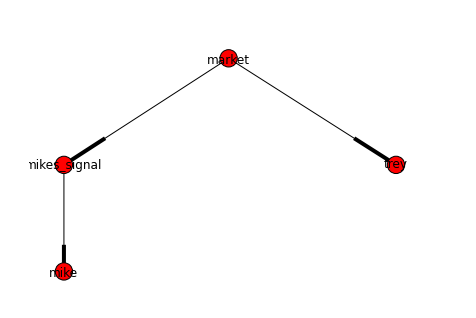

In [74]:
#The Solvers and input
params = pynfg.levelksolutions.br_dict(Game, 20000, 500, tol=1000, L0Dist='uniform', beta=.01)
brgame = pynfg.levelksolutions.BestResponse(Game, params)
brgame.Game.node_dict['market'].set_value('h')
brgame.Game.node_dict['market'].draw_value()
brgame.Game.node_dict['mikes_signal'].draw_value()
Game.draw_graph()

In [75]:
# This is used to get Trey's CPT from the dictionary to the ndarray above
from numpy.testing import assert_almost_equal
both_pure_l1 = np.asarray([[0,0,1,0,0,0],[0,0,1,0,0,0]])
trey_logit_l1 = np.zeros((2,6))
for i, j in zip(range(10,70,10), range(6)):
    trey_logit_l1[0,j], trey_logit_l1[1,j] = trey_qre_l1_d1[i], trey_qre_l1_d2[i]

In [76]:
brgame.train_node('trey', 1, logit=False)
assert_almost_equal(brgame.Game.node_dict['trey'].LevelCPT[1], both_pure_l1)

Training trey at level 1


In [77]:
brgame.train_node('trey', 1, logit=True)
assert_almost_equal(brgame.Game.node_dict['trey'].LevelCPT[1], trey_logit_l1, decimal=2)

Training trey at level 1


In [78]:
brgame.train_node('mike', 1, logit=False)
assert_almost_equal(brgame.Game.node_dict['mike'].LevelCPT[1], both_pure_l1, decimal=2)

Training mike at level 1


In [79]:
brgame.train_node('mike', 1, logit = True)
assert_almost_equal(brgame.Game.node_dict['mike'].LevelCPT[1], np.vstack((mike_l1_s1_qre, mike_l1_s2_qre)), decimal=2)

Training mike at level 1


To test further levels, the following input cell defines a function that takes as an input a level for each player and returns their equilibrium strategy.

In [80]:
# These are all helper functions to generate the analytical equilibrium for any level of 
# the players.

s1 =.8
s2=.7
def treylk(signal, mikeshigh=np.ones(6)/6., mikeslow=np.ones(6)/6., returnEU=False):
    if signal == 'h':
        EU = s1 *EU_H(strats, mikeshigh) + (1-s1)*EU_H(strats, mikeslow)
        if returnEU:
            return EU
        return lqre(EU, .01)
    if signal == 'l':
        EU = s2 *EU_L(strats, mikeshigh) + (1-s2)*EU_L(strats, mikeslow)
        if returnEU:
            return EU
        return lqre(EU, .01)

def mikelk(signal, treyhigh = np.ones(6)/6., treylow = np.ones(6)/6., beta=.01, returnEU=False):
    if signal =='h':
        high_m = phigh('h')
        EU = high_m * EU_H(strats, treyhigh) + (1-high_m)*EU_L(strats, treylow)
        if returnEU:
            return EU
        return lqre(EU, beta)
    if signal =='l':
        high_m = phigh('l')
        EU = high_m * EU_H(strats, treyhigh) + (1-high_m)*EU_L(strats, treylow)
        if returnEU:
            return EU
        return lqre(EU, beta)

def genCPT(Lmike=3, Ltrey=3):
    probs = np.ones(6)/6.
    mikelkh = np.copy(probs)
    mikelkl = np.copy(probs)
    treylkh = np.copy(probs)
    treylkl = np.copy(probs)
    CPT ={'trey': None, 'mike': None}
    if Lmike == 0:
        CPT['mike'] = np.array([mikelkh, mikelkl])
    if Ltrey == 0:
        CPT['trey'] = np.array([treylkh, treylkl])
    for lev in range(max(Lmike, Ltrey)):
        mikelkh_temp, mikelkl_temp = mikelk('h', treyhigh = treylkh, treylow = treylkl), mikelk('l', treyhigh = treylkh, treylow = treylkl)
        treylkh, treylkl = treylk('h', mikeshigh=mikelkh, mikeslow=mikelkl), treylk('l', mikeshigh=mikelkh, mikeslow=mikelkl)
        mikelkh, mikelkl = mikelkh_temp, mikelkl_temp
        if Lmike ==lev +1:
            CPT['mike'] = np.array([mikelkh, mikelkl])
        if Ltrey ==lev+1:
            CPT['trey'] = np.array([treylkh, treylkl])
    return CPT

l2 = genCPT(2,2)

In [81]:
brgame.train_node('trey', 2, logit=True)
brgame.train_node('mike', 2, logit=True)

Training trey at level 2
Training mike at level 2

In [82]:
assert_almost_equal(brgame.Game.node_dict['trey'].LevelCPT[2], l2['trey'], decimal=1)

In [83]:
assert_almost_equal(brgame.Game.node_dict['mike'].LevelCPT[2], l2['mike'], decimal=1)